In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
database_1 = pd.read_csv('C:/Users/Infovesta PC-04/Documents/Database/Database Ringkas/Database Part 1.csv')
database_2 = pd.read_csv('C:/Users/Infovesta PC-04/Documents/Database/Database Ringkas/Database Part 2.csv')
database_3 = pd.read_csv('C:/Users/Infovesta PC-04/Documents/Database/Database Ringkas/Database Part 3.csv')
database_4 = pd.read_csv('C:/Users/Infovesta PC-04/Documents/Database/Database Ringkas/Database Part 4.csv')
database = pd.concat([database_1,database_2,database_3,database_4])

In [5]:
# Finding Averages and Standard Deviation

one_month = 21
rolling_dic = {'1 Month':one_month,'3 Month':one_month*3,'6 Month':one_month*6,'1 Year':one_month*12}
def rolling_average(df,param,period, stats):
    init_list = ['Kode','Date']
    init_list.append(param)
    df['Kode + Date'] = df['Kode'] + df['Date'].astype('str')
    df_ = df[init_list]
    list_df = []
    if stats == 'mean':
        for i in set(list(df_['Kode'])):
            df_i = df_[df_['Kode']==i]
            df_i[f'Average {param} {period}'] = df_i[f'{param}'].rolling(rolling_dic[period],min_periods=1).mean() # Min 1 data point
            list_df.append(df_i)
        df__ = pd.concat(list_df).sort_values(by=['Kode','Date'])
        df__['Kode + Date'] = df__['Kode'].astype('str') + df__['Date'].astype('str')
        df__ = df__.drop_duplicates(subset='Kode + Date')
        df = df.merge(df__[[f'Average {param} {period}','Kode + Date']],on='Kode + Date',how='left')            
    elif stats == 'stddev': ## Standard Deviation condition
        for i in set(list(df_['Kode'])):
            df_i = df_[df_['Kode']==i]
            df_i[f'Standard Deviation {param} {period}'] = df_i[f'{param}'].rolling(rolling_dic[period],min_periods=1).std() # Min 1 data point
            list_df.append(df_i)
        df__ = pd.concat(list_df).sort_values(by=['Kode','Date'])
        df__['Kode + Date'] = df__['Kode'].astype('str') + df__['Date'].astype('str')
        df__ = df__.drop_duplicates(subset='Kode + Date')
        df = df.merge(df__[[f'Standard Deviation {param} {period}','Kode + Date']],on='Kode + Date',how='left')
    else:
        print("Wrong stats, add 'mean' or 'stddev' into the function!")

    return df

In [6]:
database = rolling_average(df=database,param='Transaction Value',period='3 Month', stats='mean')

C:\Users\Infovesta PC-04\AppData\Local\Temp\ipykernel_9996\1841976292.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i[f'Average {param} {period}'] = df_i[f'{param}'].rolling(rolling_dic[period],min_periods=1).mean() # Min 1 data point
C:\Users\Infovesta PC-04\AppData\Local\Temp\ipykernel_9996\1841976292.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i[f'Average {param} {period}'] = df_i[f'{param}'].rolling(rolling_dic[period],min_periods=1).mean() # Min 1 data point
C:\Users\Infovesta PC-

In [7]:
universe = pd.read_excel('C:/Users/Infovesta PC-04/project_pegadaian/universe_creation/Konstituen Pegadaian.xlsx').drop('Nama', axis=1)
database = database.drop_duplicates().drop("Unnamed: 0", axis=1)
universe = universe.merge(database,on='Kode',how='left')
universe

,Kode,Date,Open Price,High Price,Low Price,Close Price,volume,Transaction Value,foreignsell,foreignbuy,...,Operating Profit Margin,Debt Ratio,Transaction Value/Frequency,Free Float,FFMC,IHSG,IHSG 1 Day Return,Rf,Rf (annualized),Average Transaction Value 3 Month
0,AALI,2008-01-02,28100.0,28350.0,27750.0,28350.0,716000,0,0.0,0.0,...,NaN,NaN,NaN,21.0,1.145863e+13,2731.5100,-0.005215,0.00585,0.0725,0.000000e+00
1,AALI,2008-01-03,28200.0,29650.0,28000.0,29650.0,1815000,0,0.0,0.0,...,NaN,NaN,NaN,21.0,1.198407e+13,2715.0601,-0.006022,0.00585,0.0725,0.000000e+00
2,AALI,2008-01-04,29400.0,30200.0,29300.0,30100.0,1404000,0,0.0,0.0,...,NaN,NaN,NaN,21.0,1.216595e+13,2765.1899,0.018464,0.00585,0.0725,0.000000e+00
3,AALI,2008-01-07,29500.0,30200.0,29500.0,29650.0,1776000,0,0.0,0.0,...,NaN,NaN,NaN,21.0,1.198407e+13,2776.4099,0.004058,0.00585,0.0725,0.000000e+00
4,AALI,2008-01-08,29700.0,30600.0,29700.0,29700.0,1601500,0,0.0,0.0,...,NaN,NaN,NaN,21.0,1.200428e+13,2785.6201,0.003317,0.00585,0.0725,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642311,PNBS,2025-03-17,50.0,50.0,50.0,50.0,20100,1005000,NaN,NaN,...,0.111696,0.826829,NaN,NaN,NaN,6471.9470,-0.006704,NaN,NaN,2.230902e+08
642312,PNBS,2025-03-18,50.0,50.0,50.0,50.0,80400,4020000,NaN,NaN,...,0.111696,0.826829,NaN,NaN,NaN,6223.3880,-0.038406,NaN,NaN,1.853291e+08
642313,PNBS,2025-03-19,50.0,50.0,50.0,50.0,154900,7745000,NaN,NaN,...,0.111696,0.826829,NaN,NaN,NaN,6311.6600,0.014184,NaN,NaN,1.758513e+08
642314,PNBS,2025-03-20,50.0,50.0,50.0,50.0,1060500,53025000,NaN,NaN,...,0.111696,0.826829,NaN,NaN,NaN,6381.6740,0.011093,NaN,NaN,1.725986e+08


In [8]:
# Perkecil Database Universe dari 2019 s.d. Sekarang

universe_2019 = universe[pd.to_datetime(universe['Date']).apply(lambda x: x.year >= 2019)]

# Buat loop untuk mencari reb_date (tanggal pertama di bursa) untuk setiap Quarter (Asumsi: setiap ganti Quarter akan Rebalancing)
reb_date = []

for quarter in universe_2019['Quarter Year'].unique():
    universe_i = universe_2019[universe_2019['Quarter Year']==quarter]
    start_date = pd.to_datetime(universe_i['Date']).min().strftime("%Y-%m-%d")
    reb_date.append(start_date)

reb_date

['2019-01-02',
 '2019-04-01',
 '2019-07-01',
 '2019-10-01',
 '2020-01-02',
 '2020-04-01',
 '2020-07-01',
 '2020-10-01',
 '2021-01-04',
 '2021-04-01',
 '2021-07-01',
 '2021-10-01',
 '2022-01-03',
 '2022-04-01',
 '2022-07-01',
 '2022-10-03',
 '2023-01-02',
 '2023-04-03',
 '2023-07-03',
 '2023-10-02',
 '2024-01-02',
 '2024-04-01',
 '2024-07-01',
 '2024-10-01',
 '2025-01-02']

In [9]:
# reb_date = ['2025-01-02','2024-09-02','2024-06-03','2024-03-01','2024-01-02','2023-09-01','2023-06-05','2023-03-01','2023-01-02',
#             '2022-09-01','2022-06-02','2022-03-01','2022-01-04','2021-09-01','2021-06-02','2021-03-01','2021-01-04','2020-09-01',
#             '2020-06-02','2020-03-02','2020-01-02','2019-09-02','2019-06-10','2019-03-01','2019-01-02']

In [10]:
drop_list = ['VISI','BDKR','GEMS','BSML','MKAP','NEST','GULA','NICE']

In [11]:
with pd.ExcelWriter(f'universe_saham_pegadaian_filter_3_bulan.xlsx') as writer:
    for i in reb_date:
        universe_i = universe[universe['Date']==i]
        universe_i = universe_i[universe_i['Average Transaction Value 3 Month']>5_000_000_000]
        universe_i = universe_i[universe_i['FFMC']>200_000_000_000]
        universe_i = universe_i[universe_i['Close Price']>50]
        universe_i = universe_i[universe_i['Ekuitas']>0]
        if datetime.strptime(i, '%Y-%m-%d')>datetime.strptime('2020-03-31', '%Y-%m-%d'):
            universe_i = universe_i[universe_i['Average Frequency 1 Month']>500]
        else: 
            pass
        universe_i = universe_i[universe_i['Distance to First Date'].str[:-5].astype('float64').fillna(0) > 120]
        for j in drop_list:
            universe_i = universe_i[universe_i['Kode']!=j]
        universe_i = universe_i[['Kode','Date','Quarter Year','Distance to First Date','Close Price','Average Transaction Value 3 Month','Average Transaction Value 1 Month','Frequency','Average Frequency 1 Month','Debt Ratio','Ekuitas','Transaction Value/Frequency',
                            'Average Market Cap 1 Month','Free Float','FFMC']]
        universe_i = universe_i.sort_values(by='FFMC',ascending=False)
        universe_i = universe_i.head(100) # Ambil 100 saham
        print(f"Date: {i}, Konstituents {len(universe_i)}")
        universe_i['Weight'] = universe_i['FFMC']/sum(universe_i['FFMC'])
        universe_i = universe_i.reset_index(drop=True)
        universe_i.to_excel(writer, index=False, sheet_name=f'{i}')

Date: 2019-01-02, Konstituents 70
Date: 2019-04-01, Konstituents 81
Date: 2019-07-01, Konstituents 81
Date: 2019-10-01, Konstituents 78
Date: 2020-01-02, Konstituents 72
Date: 2020-04-01, Konstituents 0
Date: 2020-07-01, Konstituents 69
Date: 2020-10-01, Konstituents 82
Date: 2021-01-04, Konstituents 100
Date: 2021-04-01, Konstituents 100
Date: 2021-07-01, Konstituents 100
Date: 2021-10-01, Konstituents 100
Date: 2022-01-03, Konstituents 100
Date: 2022-04-01, Konstituents 100
Date: 2022-07-01, Konstituents 100
Date: 2022-10-03, Konstituents 100
Date: 2023-01-02, Konstituents 100
Date: 2023-04-03, Konstituents 100
Date: 2023-07-03, Konstituents 100
Date: 2023-10-02, Konstituents 100
Date: 2024-01-02, Konstituents 100
Date: 2024-04-01, Konstituents 100
Date: 2024-07-01, Konstituents 100
Date: 2024-10-01, Konstituents 100
Date: 2025-01-02, Konstituents 100


In [12]:
universe_excel = []

for date in reb_date:
    universe_excel_i = pd.read_excel('universe_saham_pegadaian_filter_3_bulan.xlsx', sheet_name=f'{date}')
    universe_excel.append(universe_excel_i)

universe_df = pd.concat(universe_excel,ignore_index=True).sort_values(['Date','Weight'], ascending=[True,False])

C:\Users\Infovesta PC-04\AppData\Local\Temp\ipykernel_9996\2956796710.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  universe_df = pd.concat(universe_excel,ignore_index=True).sort_values(['Date','Weight'], ascending=[True,False])


In [13]:
universe_df

,Kode,Date,Quarter Year,Distance to First Date,Close Price,Average Transaction Value 3 Month,Average Transaction Value 1 Month,Frequency,Average Frequency 1 Month,Debt Ratio,Ekuitas,Transaction Value/Frequency,Average Market Cap 1 Month,Free Float,FFMC,Weight
0,BBCA,2019-01-02,Q12019,4018 days,5240.0,4.016947e+11,494365642875,NaN,NaN,0.820136,143705181000000,NaN,6.393660e+14,43.10213,2.784231e+14,0.150732
1,BBRI,2019-01-02,Q12019,4018 days,3610.0,3.770361e+11,426154138900,NaN,NaN,0.851779,175399411000000,NaN,5.520537e+14,43.24736,2.366184e+14,0.128100
2,TLKM,2019-01-02,Q12019,4018 days,3730.0,3.216441e+11,324128582700,NaN,NaN,0.481256,106287000000000,NaN,3.688086e+14,47.89960,1.769900e+14,0.095819
3,ASII,2019-01-02,Q12019,4018 days,8200.0,2.622168e+11,299457763375,NaN,NaN,0.496194,167931000000000,NaN,3.371268e+14,49.83551,1.654365e+14,0.089564
4,BMRI,2019-01-02,Q12019,4018 days,3662.5,2.727699e+11,287444782750,NaN,NaN,0.849804,176277019000000,NaN,3.470250e+14,39.99080,1.367019e+14,0.074008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2228,MAPA,2025-01-02,Q12025,2373 days,1055.0,1.891521e+10,10808478025,957,1816.60,0.447075,6804191000000,4.031803e+06,2.934487e+12,30.70081,9.232262e+11,0.000412
2229,ASSA,2025-01-02,Q12025,4434 days,685.0,5.660477e+09,2580232975,341,658.10,0.632255,2794210314905,2.640035e+06,2.566263e+12,36.43302,9.211831e+11,0.000411
2230,PTRO,2025-01-02,Q12025,6210 days,2745.0,1.263276e+11,149062108750,10940,7382.35,0.673344,3743627088000,1.877147e+07,2.593502e+12,26.26376,7.271439e+11,0.000324
2231,TOBA,2025-01-02,Q12025,4563 days,406.0,3.163001e+10,10390285340,1310,2003.90,0.512050,6888316260264,5.284301e+06,3.530468e+12,20.87053,6.869160e+11,0.000306


In [14]:
# Buat Reb Komp in case butuh backtesting nanti

reb_date_df = pd.DataFrame({'reb_date':reb_date})
kode_date_list = []
universe_list = []

for date in universe_df['Date'].unique():
    stock_i = universe_df[universe_df['Date']==date]
    from_date = stock_i['Date'].values[0]
    if date != reb_date_df.max().iloc[0]:
        to_date_ind = reb_date_df[reb_date_df['reb_date']==from_date].index + 1
        to_date = reb_date_df.loc[[to_date_ind[0]]].values[0][0]
        # print(f"kode: {stock_i['Kode'].unique()[0]}, from date: {from_date}, to date: {to_date}")
        stock_i['From'] = from_date
        stock_i['To'] = to_date
    else:
        stock_i['From'] = from_date
        stock_i['To'] = database['Date'].max()
    universe_list.append(stock_i[['Kode','From','To']])


reb_komp = pd.concat(universe_list)

C:\Users\Infovesta PC-04\AppData\Local\Temp\ipykernel_9996\4065387537.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_i['From'] = from_date
C:\Users\Infovesta PC-04\AppData\Local\Temp\ipykernel_9996\4065387537.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_i['To'] = to_date
C:\Users\Infovesta PC-04\AppData\Local\Temp\ipykernel_9996\4065387537.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [15]:
check_db = database[database['Kode'].isin(reb_komp['Kode'].unique())].sort_values(['Date', 'FFMC'],ascending=[True,False])
check_db['Price Change'] = check_db['Close Price']/check_db['Prev Close Price']-1

In [17]:
check_db = rolling_average(df=check_db,param='Price Change',period='3 Month', stats='stddev')
check_db = rolling_average(df=check_db,param='Price Change',period='6 Month', stats='stddev')
check_db = rolling_average(df=check_db,param='Price Change',period='1 Year', stats='stddev')

C:\Users\Infovesta PC-04\AppData\Local\Temp\ipykernel_9996\1841976292.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i[f'Standard Deviation {param} {period}'] = df_i[f'{param}'].rolling(rolling_dic[period],min_periods=1).std() # Min 1 data point
C:\Users\Infovesta PC-04\AppData\Local\Temp\ipykernel_9996\1841976292.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i[f'Standard Deviation {param} {period}'] = df_i[f'{param}'].rolling(rolling_dic[period],min_periods=1).std() # Min 1 data point
C:

In [24]:
check_db.groupby(['Kode'])[["Standard Deviation Price Change 3 Month", "Standard Deviation Price Change 6 Month", "Standard Deviation Price Change 1 Year"]].describe().T.to_excel("Stddev Check.xlsx")

<Axes: >

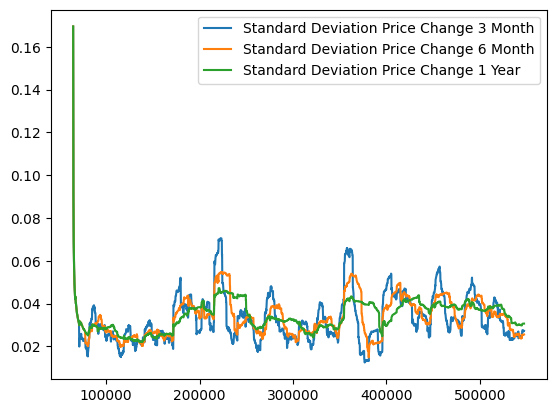

In [39]:
import matplotlib as plt
check_db[check_db['Kode'] == 'WINS'][["Date", "Standard Deviation Price Change 3 Month", "Standard Deviation Price Change 6 Month", "Standard Deviation Price Change 1 Year"]].plot()